# Project Checkpoint 1: Dataset Comparison, Selection, and EDA

# (A) 3 Candidate Datasets

1) MovieLens 25M (user–item graph)

Dataset name + source:

MovieLens 25M (ml-25m) from GroupLens.

https://grouplens.org/datasets/movielens/25m/

Course topic:

Graph mining (bipartite user–movie graph), similarity-based recommendation, clustering/community-like structure

Potential beyond-course techniques :

Matrix factorization (implicit/explicit), Bayesian Personalized Ranking (BPR)

Neural collaborative filtering / deep recommenders

Graph embeddings (node2vec)

Dataset size + structure:

25,000,095 ratings, 1,093,360 tags, 62,423 movies, 162,541 users; timestamps from 1995–2019.

Data types: userId (int), movieId (int), rating (float), timestamp; plus tags and movie metadata via movies.csv (title/genres).

Target variable(s):

Supervised-style: rating prediction

Ranking/recommender: next-item / top-N recommendation (implicit feedback derived from ratings)

Licensing/usage constraints:

https://files.grouplens.org/datasets/movielens/ml-25m-README.html

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

<br><br>


2) Amazon Product Reviews + Metadata (Text + user–item graph + “bought/viewed” edges)

Dataset name + source:

SNAP / UCSD Amazon product data (“Amazon product data” by McAuley, UCSD).
https://snap.stanford.edu/data/amazon/productGraph/

Course topic:

graph mining (user–item interactions; product–product “also bought/viewed” graphs), clustering (products/users)

Potential beyond-course techniques:

Transformer-based review embeddings (e.g., sentence transformers) for semantic clustering, anomaly detection (spam/helpfulness anomalies)

Graph neural networks for recommendation or link prediction on product graphs

Contrastive learning for product representations (text + graph + metadata)

Dataset size + structure:

Page states 143.7 million reviews (May 1996–July 2014), includes review text/ratings/helpfulness + product metadata + product–product links (“also viewed/also bought”).

Data types: reviewerID/user, ASIN/productID, rating, reviewText, summary, time; metadata like category/brand/price; graph edges for related products.

Target variable(s):

rating prediction (supervised), helpfulness prediction, review sentiment, recommendation ranking, link prediction in product graph

Licensing/usage constraints:

Research dataset hosted by SNAP/UCSD;

Justifying recommendations using distantly-labeled reviews and fined-grained aspects

Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

<br><br>

3) Yelp Reviews (Text classification + topic modeling)

Dataset name + source:

Yelp/yelp_review_full (Hugging Face datasets).
https://huggingface.co/datasets/Yelp/yelp_review_full

Course topic:

text mining (TF-IDF/embeddings), classification, clustering (embedding space)

Potential beyond-course techniques:

BERTopic / neural topic modeling (transformer embeddings + clustering)

Fine-tuning transformer classifiers (DistilBERT/RoBERTa) for star prediction

Dataset size + structure:

700,000 rows total; 650k train + 50k test, balanced across 1–5 stars.

Data types: text review + label (1–5 stars).

Target variable(s): star rating (classification)

Licensing/usage constraints:

If you use the official Yelp Open Dataset, it is intended for academic/non-commercial use and governed by Yelp’s dataset terms.

https://s3-media3.fl.yelpcdn.com/assets/srv0/engineering_pages/bea5c1e92bf3/assets/vendor/yelp-dataset-agreement.pdf

# B) Comparative Analysis of Datasets

| Dimension                            | MovieLens 25M                                                                                                                 | Amazon Reviews                                                                                                                                         | Yelp Reviews (HF / Open Dataset)                                                                                                                                  |
| ------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Supported tasks (course vs external) | **Course:** graph-based similarity, clustering users/items. **External:** matrix factorization / neural CF / graph embeddings | **Course:** text mining + graph mining + clustering. **External:** GNN recommenders; transformer embeddings; multimodal representations                            | **Course:** text mining + supervised classification. **External:** topic modeling (BERTopic); transformer fine-tuning                                             |
| Data quality issues                  | Missingness minimal; but **ratings are selective** (not random exposure), timestamps span decades ([files.grouplens.org][1])  | **Huge + heterogeneous**; messy metadata fields vary by category; cold-start issues; potential duplicates across versions ([Stanford Network Analysis Project][2]) | Noisy text; potential domain bias by business types; dataset is balanced by design in HF packaging ([Hugging Face][3])                                            |
| Algorithmic feasibility (Colab)      | Feasible on full data for many tasks; graph methods scale well; MF/ALS feasible                                               | Full dataset is too big; must use **category subsets** or sampling; graph+text can be heavy ([Stanford Network Analysis Project][2])                               | Very feasible: 700k is manageable; transformer training may need GPU/time budgeting ([Hugging Face][3])                                                           |
| Bias considerations                  | **Selection/exposure bias:** users rate what they chose to watch; popularity bias                                             | **Recommendation + popularity bias** (“also bought/viewed” reflects platform exposure); review bias (who reviews)                                                  | **Review selection bias:** extreme experiences more likely; platform/community norms; possible demographic/geo skews                      |
| Ethical considerations               | Low personal sensitivity; still avoid re-identification attempts                                                              | User-generated text; handle responsibly; avoid deanonymization                                                                                                     | User-generated text; don’t target individuals; academic/non-commercial constraints on official dataset |

[1]: https://files.grouplens.org/datasets/movielens/ml-25m-README.html?utm_source=chatgpt.com "ml-25m-README.html"
[2]: https://snap.stanford.edu/data/amazon/productGraph/?utm_source=chatgpt.com "Amazon product data"
[3]: https://huggingface.co/datasets/Yelp/yelp_review_full?utm_source=chatgpt.com "Yelp/yelp_review_full · Datasets at ..."



# C) Selected Dataset: MovieLens 25M (GroupLens)

Reasons :

course alignment:

Natural user–movie bipartite graph supports graph mining tasks (e.g., degree distributions, similarity graphs, clustering of users/items, temporal dynamics).

Supports course-style recommendation / similarity baselines (user-user / item-item KNN) and graph analysis.

Beyond-course technique:

Matrix factorization (e.g., SVD-style latent factors) for recommendation. This goes beyond “basic similarity” methods and is a standard modern approach for recommenders.

Trade-offs:

No “ground-truth” labels for clustering; evaluation focuses on recommendation metrics (RMSE / ranking metrics).

Strong selection/exposure bias (users rate what they chose to watch), which limits causal claims.


# D) Basic EDA Data Analysis

In [ ]:
!pip -q install pandas numpy matplotlib scikit-learn scipy

import os, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [10]:
DATA_DIR = Path("data/ml-25m")
ZIP_PATH = Path("ml-25m.zip")

url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"

if not DATA_DIR.exists():
    DATA_DIR.parent.mkdir(parents=True, exist_ok=True)
    if not ZIP_PATH.exists():
        print("Downloading...")
        urllib.request.urlretrieve(url, ZIP_PATH)
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_DIR.parent)

# Core files
ratings_path = DATA_DIR / "ratings.csv"
movies_path  = DATA_DIR / "movies.csv"
tags_path    = DATA_DIR / "tags.csv"

ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)
tags    = pd.read_csv(tags_path)

print("ratings:", ratings.shape)
print("movies :", movies.shape)
print("tags   :", tags.shape)
ratings.head()


ratings: (25000095, 4)
movies : (62423, 3)
tags   : (1093360, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
def basic_profile(df, name):
    print(f"\n--- {name} ---")
    print(df.dtypes)
    print(df.isna().mean().sort_values(ascending=False).head(10))
    print(df.describe(include="all").T.head(10))

basic_profile(ratings, "ratings")
basic_profile(movies, "movies")
basic_profile(tags, "tags")

# Non-trivial checks
assert {"userId","movieId","rating","timestamp"}.issubset(ratings.columns)
assert ratings["rating"].between(0.5, 5.0).all(), "Ratings outside expected scale (0.5–5.0)"
assert ratings["userId"].nunique() > 1000 and ratings["movieId"].nunique() > 1000
print("\nSanity checks passed.")



--- ratings ---
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64
                count          mean           std          min           25%  \
userId     25000095.0  8.118928e+04  4.679172e+04          1.0  4.051000e+04   
movieId    25000095.0  2.138798e+04  3.919886e+04          1.0  1.196000e+03   
rating     25000095.0  3.533854e+00  1.060744e+00          0.5  3.000000e+00   
timestamp  25000095.0  1.215601e+09  2.268758e+08  789652009.0  1.011747e+09   

                    50%           75%           max  
userId     8.091400e+04  1.215570e+05  1.625410e+05  
movieId    2.947000e+03  8.623000e+03  2.091710e+05  
rating     3.500000e+00  4.000000e+00  5.000000e+00  
timestamp  1.198868e+09  1.447205e+09  1.574328e+09  

--- movies ---
movieId     int64
title      object
genres     object
dtype: object
movieId    0.0
title      0.0
genres     0.0
dt

In [ ]:
ratings_clean = ratings.copy()

# WHY: Datetime makes temporal drift & seasonality analysis easier.
ratings_clean["ts"] = pd.to_datetime(ratings_clean["timestamp"], unit="s", errors="coerce")

# WHY: Duplicate rows can inflate counts and bias evaluation.
before = len(ratings_clean)
ratings_clean = ratings_clean.drop_duplicates(subset=["userId","movieId","rating","timestamp"])
after = len(ratings_clean)
print("Dropped duplicates:", before - after)

# Join movie metadata
df = ratings_clean.merge(movies, on="movieId", how="left")
assert df["title"].isna().mean() < 0.01, "Too many missing titles after merge"
df.head()


Dropped duplicates: 0


,userId,movieId,rating,timestamp,ts,title,genres
0,1,296,5.0,1147880044,2006-05-17 15:34:04,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,2006-05-17 12:26:57,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,2006-05-17 12:27:08,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,2006-05-17 15:13:40,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,2006-05-17 12:21:50,Singin' in the Rain (1952),Comedy|Musical|Romance


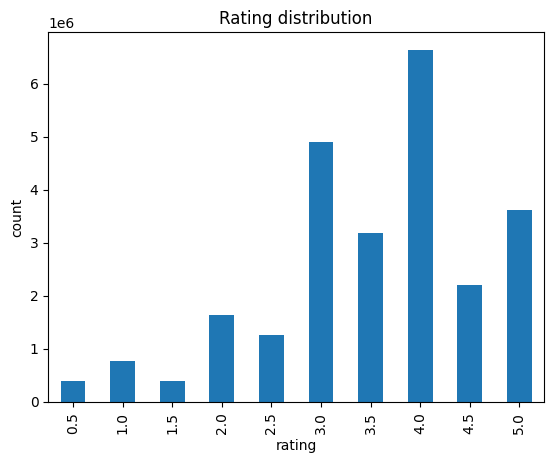

In [ ]:
plt.figure()
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("rating")
plt.ylabel("count")
plt.show()


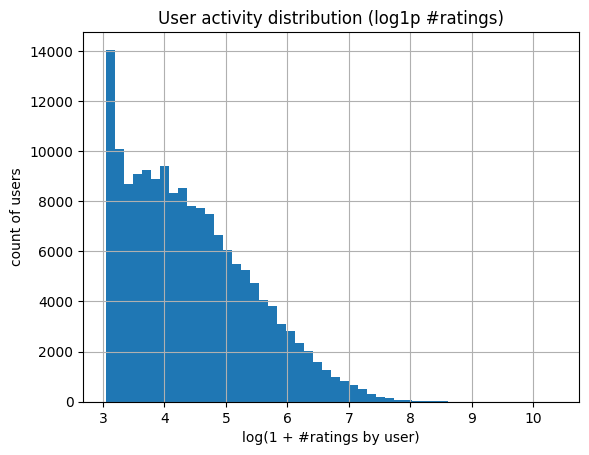

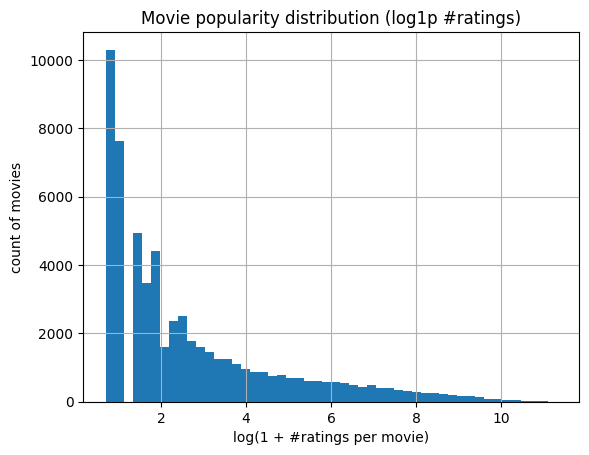

In [ ]:
user_counts = df.groupby("userId").size()
movie_counts = df.groupby("movieId").size()

plt.figure()
np.log1p(user_counts).hist(bins=50)
plt.title("User activity distribution (log1p #ratings)")
plt.xlabel("log(1 + #ratings by user)")
plt.ylabel("count of users")
plt.show()

plt.figure()
np.log1p(movie_counts).hist(bins=50)
plt.title("Movie popularity distribution (log1p #ratings)")
plt.xlabel("log(1 + #ratings per movie)")
plt.ylabel("count of movies")
plt.show()


In [ ]:
n_users = df["userId"].nunique()
n_movies = df["movieId"].nunique()
n_ratings = len(df)

density = n_ratings / (n_users * n_movies)
print(f"Users: {n_users:,}  Movies: {n_movies:,}  Ratings: {n_ratings:,}")
print(f"User–item matrix density ≈ {density:.6%} (very sparse)")


Users: 162,541  Movies: 59,047  Ratings: 25,000,095
User–item matrix density ≈ 0.260484% (very sparse)


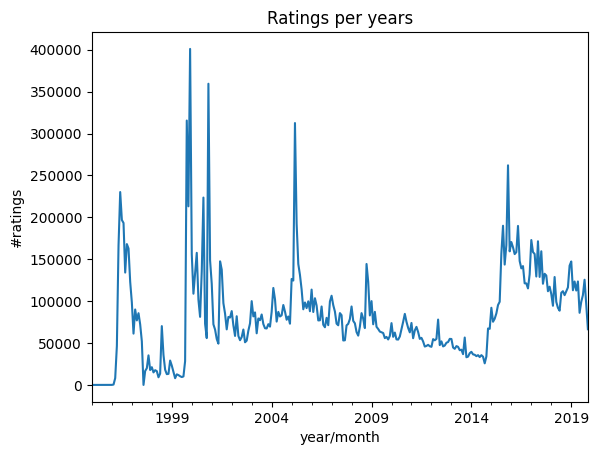

In [ ]:
ratings_by_month = df.set_index("ts").resample("MS")["rating"].count()

plt.figure()
ratings_by_month.plot()
plt.title("Ratings per years")
plt.xlabel("year/month")
plt.ylabel("#ratings")
plt.show()


# E) Initial Insights and Direction

Observation: The user activity and movie popularity distributions are heavy-tailed (a few users/movies dominate).

Implication: Simple similarity models may over-recommend popular movies; we should measure popularity bias and consider regularization.

Observation: The user–item matrix is pretty sparse.

Hypothesis: Latent factor models (matrix factorization) maybe generalize better than pure neighbor methods under sparsity.

Potential Research Questions :

How does filtering (e.g., keeping only users with ≥ N ratings) affect recommender performance and bias?

For users with very few ratings (or movies with few ratings), which method produces more reasonable recommendations, and what types of errors do we observe (over-popular, genre mismatch, etc.)?

Do recommenders behave differently across user groups (heavy raters vs. casual raters), and can clustering users by rating behavior (or genre preferences) help explain where each model succeeds or fails?

# F) Github
https://github.com/HuigangQu/Data-mining-project

On my honor, I declare the following resources:
1. Collaborators:
- none

2. Web Sources:
- https://grouplens.org/datasets/movielens/25m/
- https://snap.stanford.edu/data/amazon/productGraph/
- https://huggingface.co/datasets/Yelp/yelp_review_full


3. AI Tools:
- ChatGPT: I prompted to get some status introduction and comparisons of the datasets I was interested, and get help build the EDA for the Movie rating dataset I chose.

4. Citations:
- F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872
- Justifying recommendations using distantly-labeled reviews and fined-grained aspects. - Jianmo Ni, Jiacheng Li, Julian McAuley Empirical Methods in Natural Language Processing (EMNLP), 2019
- Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).